# Импорт библиотек

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install datasets

In [78]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from tqdm.notebook import tqdm
import unicodedata
import numpy as np
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as M

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/kaggle/input/spamham/train_spam.csv')
data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


# Анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


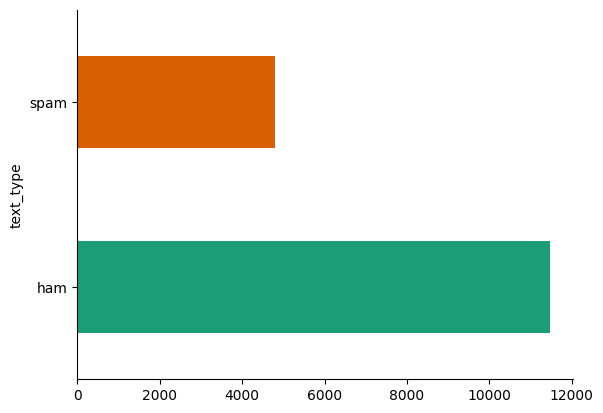

In [5]:
data.groupby('text_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

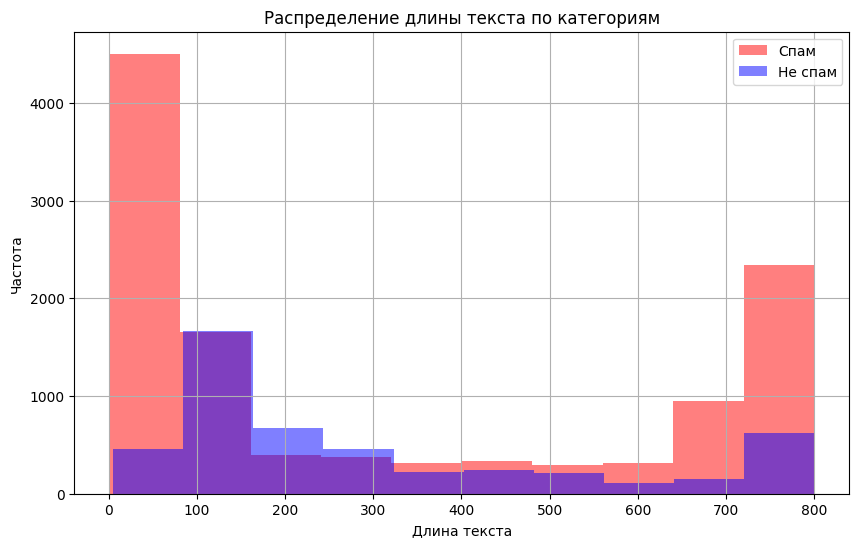

In [6]:
data['text_length'] = data.text.str.len()
data[data['text_type'] == 'ham']
plt.figure(figsize=(10, 6))
plt.hist(data[data['text_type'] == 'ham']['text_length'].tolist(), bins=10, alpha=0.5, color='r', label='Спам')
plt.hist(data[data['text_type'] == 'spam']['text_length'].tolist(), bins=10, alpha=0.5, color='b', label='Не спам')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.title('Распределение длины текста по категориям')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

***Облако слов для категории "Не спам"***

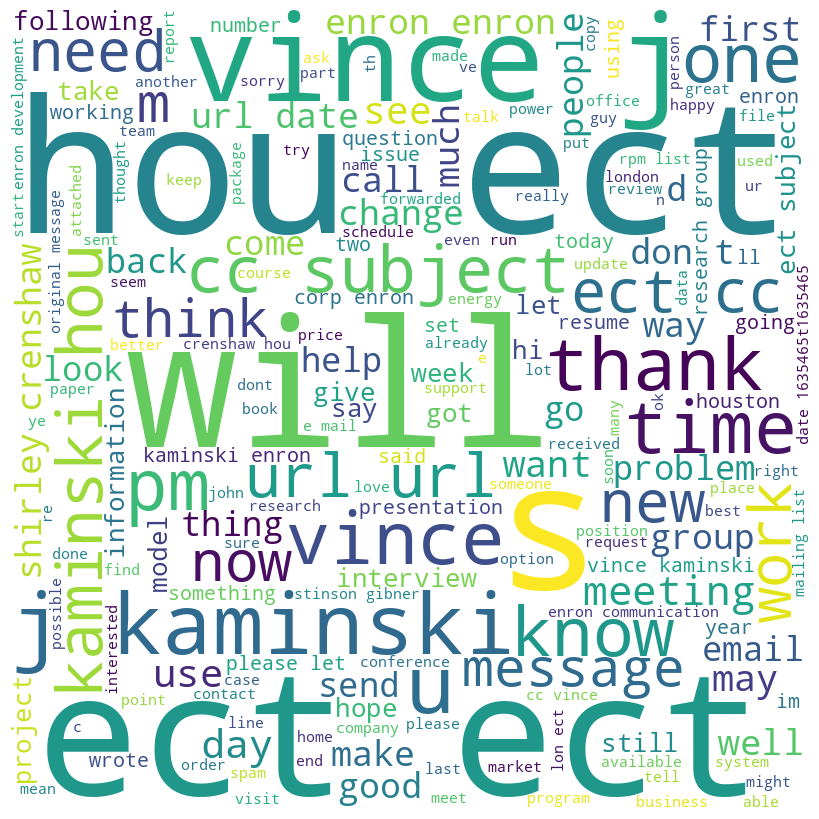

In [76]:
text_data = " ".join(data[data['text_type'] == 'ham']['text'])
wordcloud = WordCloud(width=800, height=800, background_color="white", stopwords=STOPWORDS, min_font_size=10)
wordcloud.generate(text_data)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

***Облако слов для категории "Спам"***

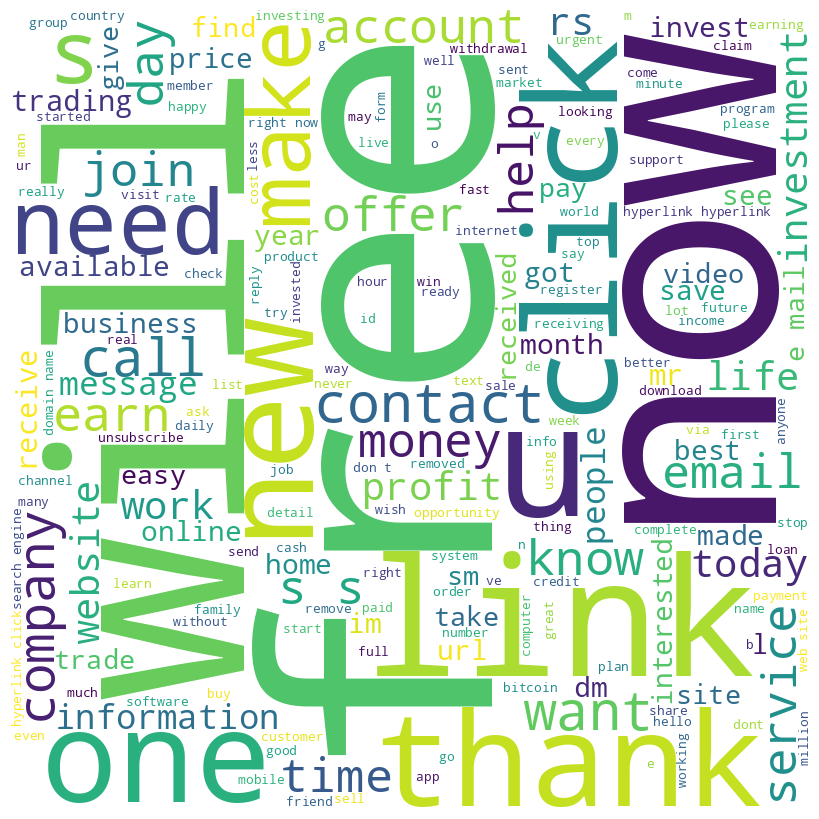

In [77]:
text_data = " ".join(data[data['text_type'] == 'spam']['text'])
wordcloud = WordCloud(width=800, height=800, background_color="white", stopwords=STOPWORDS, min_font_size=10)
wordcloud.generate(text_data)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Облаки слов показывают, что самыми распространенными словами в СПАМах - это: free, click, now, link, new.

In [7]:
data.text.str.split().str.len().mean() # среднее количество слов в предложении

56.81643936601548

# Нейросетевые модели

# Предобработка

In [8]:
data['text'] = data['text'].apply(lambda text: unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8'))
data.head() # приведение стилей к обычному

,text_type,text,text_length
0,ham,make sure alex knows his birthday is over in f...,86
1,ham,a resume for john lavorato thanks vince i will...,520
2,spam,plzz visit my website moviesgodml to get all m...,126
3,spam,urgent your mobile number has been awarded wit...,139
4,ham,overview of hr associates analyst project per ...,733


In [9]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
def preprocess_text(text): # удаление всех символов, кроме букв, приведение к нижнему регистру
    tokenizer = RegexpTokenizer("\w+")
    tokens = tokenizer.tokenize(text.lower())
    return tokens

train_df['tokens'] = train_df['text'].apply(preprocess_text)
train_df.head() 

,text_type,text,text_length,tokens
1157,ham,going to take your babe out,27,"[going, to, take, your, babe, out]"
3474,ham,ken attached is a correction to pages 10 11 an...,360,"[ken, attached, is, a, correction, to, pages, ..."
4084,ham,except android is a cucked,26,"[except, android, is, a, cucked]"
1383,spam,stop been afraid stop the procrastination make...,285,"[stop, been, afraid, stop, the, procrastinatio..."
14626,ham,on aug 1635465 bort paul wrote if your sendmai...,708,"[on, aug, 1635465, bort, paul, wrote, if, your..."


In [11]:
test_df['tokens'] = test_df['text'].apply(preprocess_text)
test_df.head()

,text_type,text,text_length,tokens
11533,spam,pi is a new digital currency developed by stan...,184,"[pi, is, a, new, digital, currency, developed,..."
5862,spam,I do beleive on forex trade after my withdrawa...,216,"[i, do, beleive, on, forex, trade, after, my, ..."
123,spam,when i earn my first $10000 on forex trade it ...,214,"[when, i, earn, my, first, 10000, on, forex, t..."
2771,ham,i dnt knw jab tayaar houngi tab bta dungi nd j...,63,"[i, dnt, knw, jab, tayaar, houngi, tab, bta, d..."
8246,ham,who told dis? naam bta,22,"[who, told, dis, naam, bta]"


In [12]:
vocab = build_vocab_from_iterator(train_df['tokens'].tolist(), specials=['<PAD>', '<UNK>'])
vocab.set_default_index(1) # токен <UNK>, если слово в тексте не найдено в вокабе
len(vocab) 

41890

In [62]:
class TextClassifierDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        Y = pd.Series(self.data.iloc[index]['text_type']).replace(['spam', 'ham'], [1, 0])[0]
        X = transform(self.data.iloc[index]['tokens'])

        return X, Y

In [63]:
transform = T.Sequential(
    T.VocabTransform(vocab), 
    T.Truncate(max_seq_len=50),
    T.ToTensor(),
    T.PadTransform(max_length=50, pad_value=0) # приведение индексов к одному размеру
)
dataset_train = TextClassifierDataset(train_df, transform)
dataset_train[0]

(tensor([ 260,    3,  156,   15, 1962,   77,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]),
 0)

In [64]:
dataset_test = TextClassifierDataset(test_df, transform)
dataset_test[0]

(tensor([ 6041,    12,     6,    74,  1142,  2009,  1763,    37,   781, 18194,
            18,   135,    89,   818,   546,  1053,     3,   795,    15,  6041,
           591,    16,   137,     5,   110,    27,  2038,     1,    34,    15,
           746,   418,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 1)

## Без использования рекуррентного слоя

In [16]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        aggregated = torch.mean(embedded, dim=1)
        hidden = torch.relu(self.fc(aggregated))
        output = self.output(hidden)
        return output

In [27]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [41]:
classes = len(data['text_type'].unique())
num_epochs = 15

model1 = TextClassifier(len(vocab), embedding_dim=128, hidden_dim=256, output_dim=classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

train_loss = []
train_auroc = []
test_auroc = []

In [42]:
%%time
for epoch in tqdm(range(num_epochs)):
    model1.train()
    running_loss = 0.0
    predictions_train = []
    labels_train = []

    auroc = M.AUROC(task="binary")
    for indices, labels in train_loader:
        indices, labels = indices.to('cuda'), labels.to('cuda')
        output = model1(indices)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

        predictions_train.extend(torch.argmax(output, dim=1).tolist())
        labels_train.extend(labels.tolist())

    train_loss.append(running_loss)

    model1.eval()
    predictions_test = []
    labels_test = []

    with torch.no_grad():
        for indices, labels in test_loader:
            indices, labels = indices.to('cuda'), labels.to('cuda')
            output = model1(indices)
            predictions_test.extend(torch.argmax(output, dim=1).tolist())
            labels_test.extend(labels.tolist())

    auc_roc_train = auroc(torch.tensor(predictions_train, dtype=torch.float32), torch.tensor(labels_train, dtype=torch.long))
    train_auroc.append(auc_roc_train)
    auc_roc_test = auroc(torch.tensor(predictions_test, dtype=torch.float32), torch.tensor(labels_test, dtype=torch.long))
    test_auroc.append(auc_roc_test)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {torch.mean(torch.tensor(running_loss))},\nROCAUC Train:{auc_roc_train}, ROCAUC Test:{auc_roc_test}\n-------------------------------')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 68.83760833740234,

ROCAUC Train:0.5503775477409363, ROCAUC Test:0.6884785890579224

-------------------------------

Epoch 2/15, Train Loss: 42.321346282958984,

ROCAUC Train:0.7946087718009949, ROCAUC Test:0.8864257335662842

-------------------------------

Epoch 3/15, Train Loss: 25.099382400512695,

ROCAUC Train:0.8982492685317993, ROCAUC Test:0.8576855659484863

-------------------------------

Epoch 4/15, Train Loss: 17.042139053344727,

ROCAUC Train:0.9354742765426636, ROCAUC Test:0.9021669030189514

-------------------------------

Epoch 5/15, Train Loss: 13.248391151428223,

ROCAUC Train:0.9513855576515198, ROCAUC Test:0.9168131947517395

-------------------------------

Epoch 6/15, Train Loss: 10.112371444702148,

ROCAUC Train:0.9611853957176208, ROCAUC Test:0.9238690137863159

-------------------------------

Epoch 7/15, Train Loss: 8.6845121383667,

ROCAUC Train:0.9687620997428894, ROCAUC Test:0.9273741245269775

-------------------------------

Epo

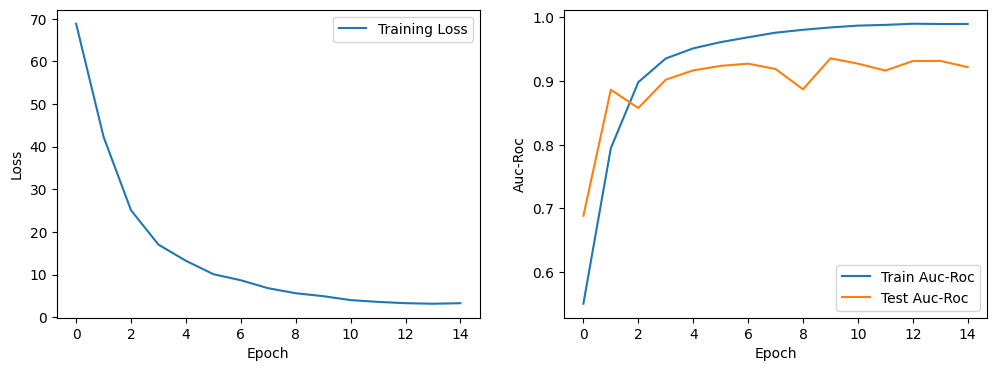

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_auroc, label='Train Auc-Roc')
plt.plot(test_auroc, label='Test Auc-Roc')
plt.xlabel('Epoch')
plt.ylabel('Auc-Roc')
plt.legend()
plt.show()

## С использованием рекуррентного слоя

In [65]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output, _ = self.rnn(output)
        output = output[:, -1, :]
        output = self.fc(torch.relu(output))
        return output

In [66]:
classes = len(data['text_type'].unique())
num_epochs = 12

model2 = LSTMModel(len(vocab), embedding_dim=128, hidden_size=128, num_classes=classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.002)

train_loss = []
train_auroc = []
test_auroc = []

In [67]:
%%time
for epoch in tqdm(range(num_epochs)):
    model2.train()
    running_loss = 0.0
    predictions_train = []
    labels_train = []

    auroc = M.AUROC(task="binary")
    for indices, labels in train_loader:
        indices, labels = indices.to('cuda'), labels.to('cuda')
        output = model2(indices)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

        predictions_train.extend(torch.argmax(output, dim=1).tolist())
        labels_train.extend(labels.tolist())

    train_loss.append(running_loss)

    model2.eval()
    predictions_test = []
    labels_test = []

    with torch.no_grad():
        for indices, labels in test_loader:
            indices, labels = indices.to('cuda'), labels.to('cuda')
            output = model2(indices)
            predictions_test.extend(torch.argmax(output, dim=1).tolist())
            labels_test.extend(labels.tolist())

    auc_roc_train = auroc(torch.tensor(predictions_train, dtype=torch.float32), torch.tensor(labels_train, dtype=torch.long))
    train_auroc.append(auc_roc_train)
    auc_roc_test = auroc(torch.tensor(predictions_test, dtype=torch.float32), torch.tensor(labels_test, dtype=torch.long))
    test_auroc.append(auc_roc_test)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {torch.mean(torch.tensor(running_loss))},\nROCAUC Train:{auc_roc_train}, ROCAUC Test:{auc_roc_test}\n-------------------------------')

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/12, Train Loss: 218.41612243652344,
ROCAUC Train:0.5908288359642029, ROCAUC Test:0.803702712059021
-------------------------------
Epoch 2/12, Train Loss: 78.92659759521484,
ROCAUC Train:0.9101519584655762, ROCAUC Test:0.9248929023742676
-------------------------------
Epoch 3/12, Train Loss: 27.510540008544922,
ROCAUC Train:0.9714150428771973, ROCAUC Test:0.9266442060470581
-------------------------------
Epoch 4/12, Train Loss: 10.860882759094238,
ROCAUC Train:0.9903082251548767, ROCAUC Test:0.9321641325950623
-------------------------------
Epoch 5/12, Train Loss: 7.421432018280029,
ROCAUC Train:0.9935302138328552, ROCAUC Test:0.9389740228652954
-------------------------------
Epoch 6/12, Train Loss: 5.234051704406738,
ROCAUC Train:0.9966383576393127, ROCAUC Test:0.9239197373390198
-------------------------------
Epoch 7/12, Train Loss: 4.37817907333374,
ROCAUC Train:0.9968023300170898, ROCAUC Test:0.9324454069137573
-------------------------------
Epoch 8/12, Train Loss: 4.

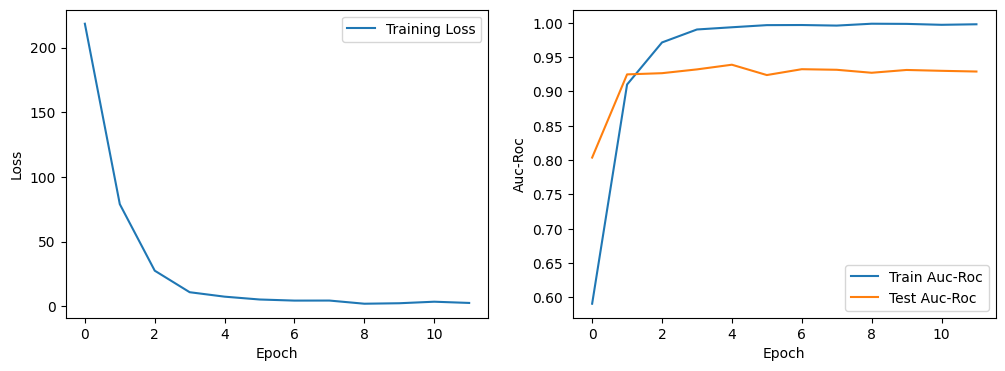

In [68]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_auroc, label='Train Auc-Roc')
plt.plot(test_auroc, label='Test Auc-Roc')
plt.xlabel('Epoch')
plt.ylabel('Auc-Roc')
plt.legend()
plt.show()

# Классические модели машинного обучения

Для получения эмбеддингов слов воспользуемся алгоритмом **Word2Vec**

In [35]:
w2v_model = Word2Vec(train_df['tokens'], vector_size=256, window=5, min_count=1, workers=4)

def text_to_embedding(tokens):
    embeddings = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    return np.mean(embeddings, axis=0)

train_df['embedding'] = train_df['tokens'].apply(text_to_embedding)
test_df['embedding'] = test_df['tokens'].apply(text_to_embedding)

In [39]:
train_df = train_df.dropna(how='any')
test_df = test_df.dropna(how='any')

In [40]:
X_train = np.stack(train_df['embedding'], axis=0)
X_test = np.stack(test_df['embedding'], axis=0)
y_train = train_df['text_type'].replace(['spam', 'ham'], [1, 0]).to_numpy()
y_test = test_df['text_type'].replace(['spam', 'ham'], [1, 0]).to_numpy()

In [42]:
X_train.shape, y_train.shape

((13012, 256), (13012,))

## Логистическая регрессия

In [51]:
model3 = LogisticRegression()

model3.fit(X_train, y_train)

y_pred = model3.predict(X_test)
print("Roc-Auc score:", roc_auc_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Roc-Auc score: 0.7887122041295177

Classification Report:

              precision    recall  f1-score   support



           0       0.87      0.91      0.89      2311

           1       0.76      0.66      0.71       935



    accuracy                           0.84      3246

   macro avg       0.81      0.79      0.80      3246

weighted avg       0.84      0.84      0.84      3246




## Метод опорных векторов

In [52]:
model4 = SVC()

model4.fit(X_train, y_train)

y_pred = model4.predict(X_test)
print("Roc-Auc score:", roc_auc_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Roc-Auc score: 0.8673424241652917

Classification Report:

              precision    recall  f1-score   support



           0       0.92      0.94      0.93      2311

           1       0.84      0.80      0.82       935



    accuracy                           0.90      3246

   macro avg       0.88      0.87      0.87      3246

weighted avg       0.90      0.90      0.90      3246




## Метод случайного леса

In [53]:
model5 = RandomForestClassifier()

model5.fit(X_train, y_train)

y_pred = model5.predict(X_test)
print("Roc-Auc score:", roc_auc_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Roc-Auc score: 0.8816464849580129

Classification Report:

              precision    recall  f1-score   support



           0       0.92      0.97      0.94      2311

           1       0.91      0.79      0.85       935



    accuracy                           0.92      3246

   macro avg       0.92      0.88      0.90      3246

weighted avg       0.92      0.92      0.92      3246




## Метод ближайших соседей

In [56]:
model6 = KNeighborsClassifier()

model6.fit(X_train, y_train)

y_pred = model6.predict(X_test)
print("Roc-Auc score:", roc_auc_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Roc-Auc score: 0.8849360301927309

Classification Report:

              precision    recall  f1-score   support



           0       0.95      0.89      0.92      2311

           1       0.76      0.88      0.82       935



    accuracy                           0.89      3246

   macro avg       0.86      0.88      0.87      3246

weighted avg       0.90      0.89      0.89      3246




# Вывод и предсказание

Основываясь на метрике Roc-Auc, полученной на валидационном наборе данных, можно сделать вывод, что наилучшей оказалась модель глубокого обучения с использованием рекурретного слоя LSTM, Однако имеет место быть небольшое переобучение, которое могло быть вызвано различными факторами, включая нехватка набора данных или строение модели.

In [69]:
data_to_pred = pd.read_csv('/kaggle/input/spamham/test_spam.csv')
data_to_pred.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [70]:
data_to_pred['text'] = data_to_pred['text'].apply(lambda text: unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8'))
data_to_pred.head() # приведение стилей к обычному

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [71]:
data_to_pred['tokens'] = data_to_pred['text'].apply(preprocess_text)
data_to_pred.head()

,text,tokens
0,j jim whitehead ejw cse ucsc edu writes j you ...,"[j, jim, whitehead, ejw, cse, ucsc, edu, write..."
1,original message from bitbitch magnesium net p...,"[original, message, from, bitbitch, magnesium,..."
2,java for managers vince durasoft who just taug...,"[java, for, managers, vince, durasoft, who, ju..."
3,there is a youtuber name saiman says,"[there, is, a, youtuber, name, saiman, says]"
4,underpriced issue with high return on equity t...,"[underpriced, issue, with, high, return, on, e..."


In [72]:
X = torch.stack([transform(tokens) for tokens in data_to_pred['tokens'].tolist()])

In [73]:
model2.eval()
with torch.no_grad():
    X = X.to('cuda')
    output = model2(X)
    predictions = torch.argmax(output, dim=1).tolist()

In [74]:
result = pd.DataFrame({'score': pd.Series(predictions).replace([1, 0], ['spam', 'ham']), 'text': data_to_pred['text']})
result.head()

,score,text
0,ham,j jim whitehead ejw cse ucsc edu writes j you ...
1,ham,original message from bitbitch magnesium net p...
2,ham,java for managers vince durasoft who just taug...
3,ham,there is a youtuber name saiman says
4,spam,underpriced issue with high return on equity t...


In [75]:
result.to_csv('result.csv', index=False)